## 데이터 불러오기 및 긍정/부정 데이터셋 생성

In [8]:
import pandas as pd

In [9]:
kakao = pd.read_csv('kakao_spell_checked.csv')
naver = pd.read_csv('naver_scored_final.csv')

In [11]:
def senti(x):
    if x >= 4:
        return 1
    elif x <= 2:
        return 0
    else:
        return None

In [12]:
kakao['sentiment'] = [senti(x) for x in kakao['평점']]
kakao = kakao[['이름','region','ko_check','sentiment']]
kakao = kakao.drop_duplicates(subset=['ko_check'])  # 중복 제거
kakao = kakao.dropna()  # none 제거

In [13]:
naver = naver[['이름','region','ko_check','평점']]
naver.columns = ['이름','region','ko_check','sentiment']

## 여기서 잠시 전처리ㄲ

#### 형태소 분석

mecab을 사용해 형태소 분석을 진행함: 이유는 빨라서


품사 태깅 관련

품사 태깅이 항상 좋은 결과를 만들어내는 것은 아닙니다.

특히, 최근 주목 받고 있는 ELMo와 BERT 같은 Contextualized Word Embedding 방법에서는 단어 주변의 문맥 정보를 전체적으로 사용하기 때문에, 주요 품사만 사용하는 방법은 효과가 안 좋을 수 있습니다.

그래서 POS Tagging을 사용해 주요 품사만 사용한 결과 값과 적용하지 않은 결과 값을 비교하는 작업이 필요합니다.

In [14]:
total = pd.concat([naver,kakao], ignore_index = True)

In [15]:
total['ko_check']

0         와 너무너무너무너무 맛있게 먹었어요 오랜만에 남편이랑 둘이서 방문했는데 이렇게 부드...
1                 맛있게 잘 먹었습니다 ㅎㅎㅎ 멘체 가츠 부드러워요 카레는 살짝 짰어요 ㅠㅠ
2                                            언제 먹어도 맛있네요 ㅎㅎ
3         필살기 돈가스 찾은 이후로 진짜 매번 방문했는데 이제서야 영수증 리뷰 써요 ㅠㅠ 가...
4         바삭한 건 없고 튀김이랑 고기랑 이중 분리되긴 했지만 잘 먹었어요 직원분이 친절하셔...
                                ...                        
254762    달인 보고 바로 다음날 사람들이 십 리 밖까지 줄 섰는데 꿋꿋이 기다려 먹은 간짜장...
254763       허름하지만 친절한 할아버지 사장님이 계시고 가격도 저렴하고 맛있는 정감 가는 중국집
254764              할머니 할아버지의 따듯한 정을 느낄 수 있는 곳 자극적이지 않아 좋아요
254765                    짬뽕 국물이 깔끔하고 가격도 기성 비갑 가격 올려도 계속 감
254766                                               정말 맛나요
Name: ko_check, Length: 254767, dtype: object

In [16]:
from konlpy.tag import Mecab
import konlpy
from tqdm import tqdm
import re
import pickle
import csv
import pandas as pd
from pandas import DataFrame 
import numpy as np

In [17]:
words = pd.read_csv('stopwords.csv', header=None)

In [18]:
stopdicts = list(words.iloc[0])

In [19]:
from konlpy.tag import Mecab

def get_nouns(tokenizer, sentence):
    
    #품사태깅 후 조사 및 불필요 형태소 제거
    tagged = tokenizer.pos(sentence)
    words = [s for s,t in tagged if t not in ['JKS','JKC','JKG','JKO','JKB','JKV','JX','JC','UNKNOWN','EC','XSA','VA', 'VV','IC','EF','ETM','XSN',''] and len(s)>0]
    
    #정규화
    verbs = [s+'다' for s,t in tagged if t in ['VA', 'VV']]
    words = words+verbs
    
    #불용어 제거 & remove 1 word
    stopwords = stopdicts + ['너무너무','입니다','셔서','히다','그래서인지','로웠','성역','시빌','대도','세요','해서','합니다','할게요','건지','비갑']
    aliveone = ['삶','차','긴','빡','씨','짰','맛','좋','잘','정','싫','또','없','있']
    words = [i for i in words if i not in stopwords and (len(i)>1) or i in aliveone ]
    
    #words = [i for i in words if len(i)>1 or i in aliveone]
    return words

def tokenize(df):
    tokenizer = Mecab(dicpath='C:/mecab/mecab-ko-dic')
    processed_data = []
    for sent in tqdm(df['ko_check']):
        processed_data.append(get_nouns(tokenizer, sent))
    return processed_data

if __name__ == '__main__':
    df = total
    df.dropna(how='any')
    processed_data = tokenize(df)
    total['token'] = processed_data

100%|████████████████████████████████████████████████████████████████████████| 254767/254767 [01:09<00:00, 3649.96it/s]


In [20]:
total.head()

,이름,region,ko_check,sentiment,token
0,필살기 돈가츠 가로수길점,강남구,와 너무너무너무너무 맛있게 먹었어요 오랜만에 남편이랑 둘이서 방문했는데 이렇게 부드...,1.0,"[오랜만, 남편, 방문, 부드러운, 돈가스, 오랜만, 봐요, 또, 방문, 맛있다, 먹다]"
1,필살기 돈가츠 가로수길점,강남구,맛있게 잘 먹었습니다 ㅎㅎㅎ 멘체 가츠 부드러워요 카레는 살짝 짰어요 ㅠㅠ,1.0,"[잘, 부드러워, 카레, 살짝, 짰, 맛있다, 먹다]"
2,필살기 돈가츠 가로수길점,강남구,언제 먹어도 맛있네요 ㅎㅎ,1.0,"[먹다, 맛있다]"
3,필살기 돈가츠 가로수길점,강남구,필살기 돈가스 찾은 이후로 진짜 매번 방문했는데 이제서야 영수증 리뷰 써요 ㅠㅠ 가...,1.0,"[필살기, 돈가스, 이후, 방문, 이제서야, 영수증, 리뷰, 써요, 가로수길, 비슷..."
4,필살기 돈가츠 가로수길점,강남구,바삭한 건 없고 튀김이랑 고기랑 이중 분리되긴 했지만 잘 먹었어요 직원분이 친절하셔...,1.0,"[바삭, 튀김, 고기, 이중, 분리, 긴, 잘, 직원, 친절, 기분, 점심, 먹다,..."


In [14]:
#1번째
total['token']

0        [와, 너무너무, 너무너무, 맛있, 게, 먹, 었, 어요, 오랜만, 에, 남편, 이...
1        [맛있, 게, 잘, 먹, 었, 습니다, ㅎㅎㅎ, 멘, 체, 가, 츠, 부드러워, 요...
2                                  [언제, 먹, 어도, 맛있, 네요, ㅎㅎ]
3        [필살기, 돈가스, 찾, 은, 이후, 로, 진짜, 매번, 방문, 했, 는데, 이제서...
4        [바삭, 한, 건, 없, 고, 튀김, 이랑, 고기, 랑, 이중, 분리, 되, 긴, ...
                               ...                        
44674    [달인, 보, 고, 바로, 다음, 날, 사람, 들, 이, 십, 리, 밖, 까지, 줄...
44676    [허름, 하, 지만, 친절, 한, 할아버지, 사장, 님, 이, 계시, 고, 가격, ...
44677    [할머니, 할아버지, 의, 따듯, 한, 정, 을, 느낄, 수, 있, 는, 곳, 자극...
44678    [짬뽕, 국물, 이, 깔끔, 하, 고, 가격, 도, 기성, 비갑, 가격, 올려도, ...
44679                                          [정말, 맛나, 요]
Name: token, Length: 254767, dtype: object

In [17]:
total['token']

0        [와, 너무너무, 너무너무, 맛있, 게, 먹, 었, 어요, 오랜만, 남편, 둘, 이...
1        [맛있, 게, 잘, 먹, 었, 습니다, ㅎㅎㅎ, 멘, 체, 가, 츠, 부드러워, 요...
2                                  [언제, 먹, 어도, 맛있, 네요, ㅎㅎ]
3        [필살기, 돈가스, 찾, 은, 이후, 진짜, 매번, 방문, 했, 는데, 이제서야, ...
4        [바삭, 한, 건, 없, 고, 튀김, 고기, 이중, 분리, 되, 긴, 했, 지만, ...
                               ...                        
44674    [달인, 보, 고, 바로, 다음, 날, 사람, 들, 십, 리, 밖, 줄, 섰, 는데...
44676    [허름, 하, 지만, 친절, 한, 할아버지, 사장, 님, 계시, 고, 가격, 저렴,...
44677    [할머니, 할아버지, 따듯, 한, 정, 느낄, 수, 있, 는, 곳, 자극, 적, 이...
44678       [짬뽕, 국물, 깔끔, 하, 고, 가격, 기성, 비갑, 가격, 올려도, 계속, 감]
44679                                          [정말, 맛나, 요]
Name: token, Length: 254767, dtype: object

In [37]:
#srop dicts 제거한 뒤
total['token']

0        [와, 너무너무, 너무너무, 맛있, 게, 먹, 었, 어요, 오랜만, 남편, 둘, 이...
1        [맛있, 게, 잘, 먹, 었, 습니다, ㅎㅎㅎ, 멘, 체, 가, 츠, 부드러워, 요...
2                                  [언제, 먹, 어도, 맛있, 네요, ㅎㅎ]
3        [필살기, 돈가스, 찾, 은, 이후, 진짜, 매번, 방문, 했, 는데, 이제서야, ...
4        [바삭, 한, 건, 없, 고, 튀김, 고기, 이중, 분리, 되, 긴, 했, 지만, ...
                               ...                        
44674    [달인, 보, 고, 바로, 다음, 날, 사람, 들, 십, 리, 밖, 줄, 섰, 는데...
44676    [허름, 하, 지만, 친절, 한, 할아버지, 사장, 님, 계시, 고, 가격, 저렴,...
44677    [할머니, 할아버지, 따듯, 한, 정, 느낄, 수, 있, 는, 곳, 자극, 적, 이...
44678       [짬뽕, 국물, 깔끔, 하, 고, 가격, 기성, 비갑, 가격, 올려도, 계속, 감]
44679                                          [정말, 맛나, 요]
Name: token, Length: 254767, dtype: object

In [12]:
total['token']

0         [너무너무, 너무너무, 오랜만, 남편, 방문, 이렇게, 부드러운, 돈가스, 오랜만,...
1                                [잘, 부드러워, 카레, 살짝, 맛있다, 먹다]
2                                             [언제, 먹다, 맛있다]
3         [필살기, 돈가스, 이후, 진짜, 매번, 방문, 이제서야, 영수증, 리뷰, 써요, ...
4         [바삭, 튀김, 고기, 이중, 분리, 잘, 직원, 친절, 셔서, 기분, 점심, 없다...
                                ...                        
254762    [달인, 바로, 다음, 사람, 꿋꿋이, 기다려, 간짜장, 맛, 지금, 짜장, 맛, ...
254763    [허름, 친절, 할아버지, 사장, 가격, 저렴, 정감, 중국집, 계시다, 맛있다, 가다]
254764                   [할머니, 할아버지, 따듯, 정, 느낄, 자극, 있다, 좋다]
254765                [짬뽕, 국물, 깔끔, 가격, 기성, 비갑, 가격, 올려도, 계속]
254766                                            [정말, 맛나다]
Name: token, Length: 254767, dtype: object

In [52]:
total['token']

0         [너무너무, 너무너무, 었, 오랜만, 남편, 둘, 방문, 했, 이렇게, 부드러운, ...
1              [잘, 었, 멘, 체, 가, 부드러워, 요, 카레, 살짝, 짰, 맛있다, 먹다]
2                                             [언제, 먹다, 맛있다]
3         [필살기, 돈가스, 이후, 진짜, 매번, 방문, 했, 이제서야, 영수증, 리뷰, 써...
4         [바삭, 한, 건, 튀김, 고기, 이중, 분리, 되, 긴, 했, 잘, 었, 직원, ...
                                ...                        
254762    [달인, 바로, 다음, 날, 사람, 십, 리, 밖, 줄, 섰, 꿋꿋이, 기다려, 간...
254763    [허름, 친절, 한, 할아버지, 사장, 가격, 저렴, 정감, 중국집, 계시다, 맛있...
254764    [할머니, 할아버지, 따듯, 한, 정, 느낄, 수, 곳, 자극, 이, 않, 있다, 좋다]
254765             [짬뽕, 국물, 깔끔, 가격, 기성, 비갑, 가격, 올려도, 계속, 감]
254766                                            [정말, 맛나다]
Name: token, Length: 254767, dtype: object

In [74]:
total['token']

0         [너무너무, 너무너무, 오랜만, 남편, 방문, 이렇게, 부드러운, 돈가스, 오랜만,...
1                             [잘, 부드러워, 카레, 살짝, 짰, 맛있다, 먹다]
2                                             [언제, 먹다, 맛있다]
3         [필살기, 돈가스, 이후, 진짜, 매번, 방문, 이제서야, 영수증, 리뷰, 써요, ...
4         [바삭, 튀김, 고기, 이중, 분리, 긴, 잘, 직원, 친절, 셔서, 기분, 점심,...
                                ...                        
254762    [달인, 바로, 다음, 사람, 꿋꿋이, 기다려, 간짜장, 맛, 지금, 짜장, 맛, ...
254763    [허름, 친절, 할아버지, 사장, 가격, 저렴, 정감, 중국집, 계시다, 맛있다, 가다]
254764                   [할머니, 할아버지, 따듯, 정, 느낄, 자극, 있다, 좋다]
254765                [짬뽕, 국물, 깔끔, 가격, 기성, 비갑, 가격, 올려도, 계속]
254766                                            [정말, 맛나다]
Name: token, Length: 254767, dtype: object

In [80]:
total['token']

0         [오랜만, 남편, 방문, 부드러운, 돈가스, 오랜만, 봐요, 방문, 할게요, 맛있다...
1                             [잘, 부드러워, 카레, 살짝, 짰, 맛있다, 먹다]
2                                                 [먹다, 맛있다]
3         [필살기, 돈가스, 이후, 방문, 이제서야, 영수증, 리뷰, 써요, 가로수길, 비슷...
4         [바삭, 튀김, 고기, 이중, 분리, 긴, 잘, 직원, 친절, 셔서, 기분, 점심,...
                                ...                        
254762    [달인, 사람, 꿋꿋이, 기다려, 간짜장, 맛, 짜장, 맛, 엄지, 입니다, 먹다,...
254763        [허름, 친절, 할아버지, 사장, 가격, 저렴, 정감, 중국집, 계시다, 맛있다]
254764                       [할머니, 할아버지, 따듯, 정, 느낄, 자극, 좋다]
254765                    [짬뽕, 국물, 깔끔, 가격, 기성, 비갑, 가격, 올려도]
254766                                                [맛나다]
Name: token, Length: 254767, dtype: object

In [85]:
total['token'].to_csv('total_token_0607.csv',  header = False, index = False, encoding='utf-8-sig')

In [87]:
total['token']

0         [오랜만, 남편, 방문, 부드러운, 돈가스, 오랜만, 봐요, 또, 방문, 맛있다, 먹다]
1                             [잘, 부드러워, 카레, 살짝, 짰, 맛있다, 먹다]
2                                                 [먹다, 맛있다]
3         [필살기, 돈가스, 이후, 방문, 이제서야, 영수증, 리뷰, 써요, 가로수길, 비슷...
4         [바삭, 튀김, 고기, 이중, 분리, 긴, 잘, 직원, 친절, 기분, 점심, 먹다,...
                                ...                        
254762       [달인, 사람, 꿋꿋이, 기다려, 간짜장, 맛, 짜장, 맛, 엄지, 먹다, 헛먹다]
254763        [허름, 친절, 할아버지, 사장, 가격, 저렴, 정감, 중국집, 계시다, 맛있다]
254764                       [할머니, 할아버지, 따듯, 정, 느낄, 자극, 좋다]
254765                        [짬뽕, 국물, 깔끔, 가격, 기성, 가격, 올려도]
254766                                                [맛나다]
Name: token, Length: 254767, dtype: object

In [21]:
#형태소 분석_ make posed dataframe
tokenizer = Mecab(dicpath='C:/mecab/mecab-ko-dic')
tagged = tokenizer.pos(total.iloc[1].ko_check)

total['tagged']= total.ko_check.apply( lambda x : tokenizer.pos(x) )
total.to_csv("total_pos.csv", header = False, index = False, encoding='utf-8-sig')

In [ ]:
total

In [28]:
#length가 1인 단어들 확인 -> 의미 있는 단어들 남기고 길이가 1인 단어들 제거
one_len_words = []
for i in total['token']:
    for j in i:
        if len(j) ==1:
            one_len_words.append(j)
            
one_len_data = pd.DataFrame(set(one_len_words)).sort_values(by=0 ,ascending=False)
pd.DataFrame(set(one_len_words)).to_csv('one_len_words.csv')

In [50]:
aliveone = ['삶','차','긴','빡','씨','짰','맛','좋','잘','정','싫','또']

In [88]:
print(total.ko_check[1])
print(total.token[1])

맛있게 잘 먹었습니다 ㅎㅎㅎ 멘체 가츠 부드러워요 카레는 살짝 짰어요 ㅠㅠ
['잘', '부드러워', '카레', '살짝', '짰', '맛있다', '먹다']


In [89]:
print(total.ko_check[0])
print(total.token[0])

와 너무너무너무너무 맛있게 먹었어요 오랜만에 남편이랑 둘이서 방문했는데 이렇게 부드러운 돈가스 오랜만에 먹 이어봐요 다음에 또 방문할게요
['오랜만', '남편', '방문', '부드러운', '돈가스', '오랜만', '봐요', '또', '방문', '맛있다', '먹다']


#### split positive, negative dataframe

In [22]:
total['final_text'] = total['token'].apply(lambda x : " ".join(x))

In [23]:
positive = total[total.sentiment==1]
negative = total[total.sentiment==0]

In [24]:
positive.head()

,이름,region,ko_check,sentiment,token,tagged,final_text
0,필살기 돈가츠 가로수길점,강남구,와 너무너무너무너무 맛있게 먹었어요 오랜만에 남편이랑 둘이서 방문했는데 이렇게 부드...,1.0,"[오랜만, 남편, 방문, 부드러운, 돈가스, 오랜만, 봐요, 또, 방문, 맛있다, 먹다]","[(와, IC), (너무너무, MAG), (너무너무, MAG), (맛있, VA), ...",오랜만 남편 방문 부드러운 돈가스 오랜만 봐요 또 방문 맛있다 먹다
1,필살기 돈가츠 가로수길점,강남구,맛있게 잘 먹었습니다 ㅎㅎㅎ 멘체 가츠 부드러워요 카레는 살짝 짰어요 ㅠㅠ,1.0,"[잘, 부드러워, 카레, 살짝, 짰, 맛있다, 먹다]","[(맛있, VA), (게, EC), (잘, MAG), (먹, VV), (었, EP)...",잘 부드러워 카레 살짝 짰 맛있다 먹다
2,필살기 돈가츠 가로수길점,강남구,언제 먹어도 맛있네요 ㅎㅎ,1.0,"[먹다, 맛있다]","[(언제, MAG), (먹, VV), (어도, EC), (맛있, VA), (네요, ...",먹다 맛있다
3,필살기 돈가츠 가로수길점,강남구,필살기 돈가스 찾은 이후로 진짜 매번 방문했는데 이제서야 영수증 리뷰 써요 ㅠㅠ 가...,1.0,"[필살기, 돈가스, 이후, 방문, 이제서야, 영수증, 리뷰, 써요, 가로수길, 비슷...","[(필살기, NNG), (돈가스, NNG), (찾, VV), (은, ETM), (이...",필살기 돈가스 이후 방문 이제서야 영수증 리뷰 써요 가로수길 비슷비슷 음식 여긴 최...
4,필살기 돈가츠 가로수길점,강남구,바삭한 건 없고 튀김이랑 고기랑 이중 분리되긴 했지만 잘 먹었어요 직원분이 친절하셔...,1.0,"[바삭, 튀김, 고기, 이중, 분리, 긴, 잘, 직원, 친절, 기분, 점심, 먹다,...","[(바삭, MAG), (한, XSA+ETM), (건, NNB+JX), (없, VA)...",바삭 튀김 고기 이중 분리 긴 잘 직원 친절 기분 점심 먹다 좋다


In [25]:
negative.head()

,이름,region,ko_check,sentiment,token,tagged,final_text
12,필살기 돈가츠 가로수길점,강남구,후기가 좋아서 갔는데 맛은 있으나 돈가스가 좀 뜨겁지 않다고 해야 하나 바로 튀긴 ...,0.0,"[후기, 맛, 돈가스, 해야, 튀긴, 미적지근, 절반, 맛, 아쉬웠, 분위기, 직원...","[(후기, NNG), (가, JKS), (좋, VA), (아서, EC), (갔, V...",후기 맛 돈가스 해야 튀긴 미적지근 절반 맛 아쉬웠 분위기 직원 친절 좋다 뜨겁다 ...
23,필살기 돈가츠 가로수길점,강남구,새우젓이랑 같이 먹는 맛이 특별했어요,0.0,"[새우젓, 맛, 특별, 먹다]","[(새우젓, NNG), (이랑, JKB), (같이, MAG), (먹, VV), (는...",새우젓 맛 특별 먹다
97,필살기 돈가츠 가로수길점,강남구,스윙스 가 좋아할 만하네요ㅋ,0.0,"[스윙스, 좋다]","[(스윙스, NNP), (가, JKS), (좋, VA), (아, EC), (할, V...",스윙스 좋다
120,후레쉬빌 삼성역본점,강남구,인 이상 예약하면 갈릭피자 개 무료라고 하고 리뷰 평점도 좋고 맛도 있다 해서 함 ...,0.0,"[예약, 갈릭, 피자, 무료, 리뷰, 평점, 맛, 맛, 평타, 긴, 뭔가, 살짝, ...","[(인, NNG), (이상, NNG), (예약, NNG), (하, XSV), (면,...",예약 갈릭 피자 무료 리뷰 평점 맛 맛 평타 긴 뭔가 살짝 아쉬운 좋다 맛있다
123,후레쉬빌 삼성역본점,강남구,플레이팅 구성이 좋아서 방문함 돈까슨데 뭔가 브런치 느낌이 저는 치즈 돈가스 먹었는...,0.0,"[레이팅, 구성, 방문, 뭔가, 브런치, 느낌, 치즈, 돈가스, 그랬, 맛, 느낌,...","[(플, NNG), (레이팅, NNG), (구성, NNG), (이, JKS), (좋...",레이팅 구성 방문 뭔가 브런치 느낌 치즈 돈가스 그랬 맛 느낌 푸짐 기분 돈가스 구...


## BOW & Vectorization

In [48]:
p_data = positive.token.values.tolist()
n_data = negative.token.values.tolist()

In [110]:
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

vectorizer = CountVectorizer(max_features=2000, min_df=5, max_df=0.5)
data_features = vectorizer.fit_transform(positive['pre_fianl'].tolist())
tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(data_features)

NameError: name 'TfidfTransformer' is not defined

In [36]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=20000, min_df=3, max_df=0.5)
X = vectorizer.fit_transform(positive['final_text'])

lda_model = LatentDirichletAllocation(n_components=2, learning_method='online', random_state=777, max_iter=1)
lda_top = lda_model.fit_transform(X)
print(lda_model.components_)
print(lda_model.components_.shape)

terms = vectorizer.get_feature_names()

def get_topics(components, feature_names, n=20):
    for idx, topic in enumerate(components):
        print("Topic %d :" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n -1:-1]])
        
get_topics(lda_model.components_, terms)

C:\Users\tkdlz\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[3.56041139e+00 2.54595896e+00 2.42622698e+00 ... 8.99949750e-01
  9.64927389e+00 8.91843531e-01]
 [1.30976935e+00 9.26269123e+02 1.60663191e+00 ... 3.42456631e+00
  5.50075406e-01 3.72463241e+01]]
(2, 12849)
Topic 1 : [('먹다', 6305.49), ('최고', 3795.35), ('고기', 2401.55), ('웨이팅', 2013.65), ('맛집', 1803.46), ('파스타', 1802.97), ('국물', 1622.97), ('생각', 1304.39), ('비싸다', 1286.88), ('피자', 1255.52), ('칼국수', 1176.34), ('만두', 1160.31), ('김치', 1142.26), ('괜찮다', 1044.41), ('냉면', 994.76), ('맛나다', 975.71), ('버거', 962.98), ('생각나다', 950.21), ('강추', 942.41), ('평양냉면', 934.99)]
Topic 2 : [('좋다', 10742.51), ('친절', 6044.08), ('분위기', 4728.22), ('음식', 3840.28), ('많다', 3490.81), ('먹다', 3268.36), ('직원', 3095.25), ('가격', 3093.32), ('방문', 2636.53), ('깔끔', 2151.14), ('서비스', 1843.48), ('사람', 1842.74), ('구성비', 1800.75), ('사장', 1789.07), ('커피', 1657.83), ('만족', 1487.1), ('메뉴', 1369.16), ('자주', 1365.84), ('추천', 1252.85), ('친구', 1226.74)]


In [104]:
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [ ]:
positive 

In [ ]:
dictionary = corpora.Dictionary(processed_data)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer = lambda x: preprocess(x,word_list))
data_features = vectorizer.fit_transform(data['Review'].tolist())
list_of_word = vectorizer.get_feature_names()

count_list = data_features.toarray().sum(axis=0)

In [62]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english', 
                     max_features=2000, min_df=5, max_df=0.5)
review_cv = cv.fit_transform(newsgroups_train.data) 

[['주말', '전시', '유명', '오므라이스', '돈가스', '맛있'],
 ['치즈', '돈가스', '맛있'],
 ['거래처',
  '고객',
  '점심',
  '치즈',
  '치즈',
  '돈가스',
  '맵싸',
  '맛있',
  '평일',
  '점심',
  '붐비',
  '생각',
  '웨이팅',
  '줄어들',
  '직원',
  '친절'],
 ['친절', '맛있', '회오리', '오므라이스', '신기', '방문'],
 ['시빌', '성역', '맛집', '파스타', '돈가스', '회사', '근처', '부드럽', '맛있'],
 ['무난'],
 ['여럿', '이것저것', '맛없', '메뉴', '실패', '한식', '맛있', '생각나'],
 ['왕새우',
  '회오리',
  '오므라이스',
  '장미',
  '돈가스',
  '추천',
  '메뉴',
  '맛있',
  '치즈',
  '떡볶이',
  '완벽',
  '사장',
  '친절',
  '쾌적'],
 [],
 ['맛있', '추천'],
 ['강추'],
 ['맛있'],
 ['시간', '음식', '빠르', '나오', '돈가스', '회오리', '오므라이스', '부드럽', '맛나', '최고'],
 ['메뉴', '정성', '번창'],
 ['맛있', '음식', '알차', '점심', '시간', '보내', '회오리', '오므라이스', '식감', '소스', '예술', '인정'],
 ['돈가스', '돈가스', '엄마', '생각나', '추억', '맛있', '만들', '아이'],
 ['친구', '맛있', '극찬', '맛있', '배부르', '매장', '깔끔', '직원', '친절'],
 ['직원', '친절', '음식', '맛있', '돈가스', '오므라이스', '맛있', '예정'],
 ['일행', '식사', '돈가스', '맛있'],
 ['친구', '주문', '꿀맛', '다음', '돈가스', '회오리', '오므라이스', '파스타', '샐러드'],
 ['분위기', '깔끔', '직원', '친절', '시빌', '정식', '치즈', '치즈',

In [ ]:
import pandas as pd 
pd.DataFrame(review_cv.toarray())

## LDA 토픽 수 최적화(Perplexity관찰)

In [26]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\tkdlz\anaconda3\lib\site-packages\matplotlib\__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\tkdlz\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\tkdlz\anaconda3\lib\site-packages\matplotlib\__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\tkdlz\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\tkdlz\anaconda3\lib\site-packages\matplotlib\__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=50000, min_df=5, max_df=0.5)
review_cv = cv.fit_transform(positive['final_text']) 

In [ ]:
#Checking the sparsity of the data
# Materialize the sparse data
data_dense = review_cv.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("sparsity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1, 
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components = i, max_iter=max_iter, 
                                        topic_word_prior= topic_word_prior, 
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs= -1,
                                        random_state=7)    
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}, coherence: {ch:0.3f}')        

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

C:\Users\tkdlz\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [136]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=50000, min_df=5, max_df=0.5)
data_vectorized = vectorizer.fit_transform(positive['final_text']) 

In [35]:
print("for positive text")
vectorizer = CountVectorizer(max_features=50000, min_df=5, max_df=0.5)
p_data_vectorized = vectorizer.fit_transform(positive['final_text']) 

print("check optimal topic num: positive text")
print("n_components with minimum perplexity:",
      show_perplexity(p_data_vectorized, start=1, end=5))

C:\Users\tkdlz\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


for positive text
check optimal topic num: positive text


AttributeError: 'LatentDirichletAllocation' object has no attribute 'get_coherence'

C:\Users\tkdlz\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


for negative text
check optimal topic num: positive text
n_components: 1, perplexity: 1529.179
n_components: 2, perplexity: 1553.054
n_components: 3, perplexity: 1607.257
n_components: 4, perplexity: 1647.959
n_components: 5, perplexity: 1714.144


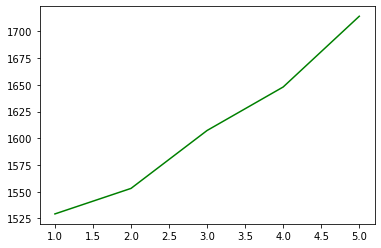

n_components with minimum perplexity: 1


In [29]:
print("for negative text")
vectorizer = CountVectorizer(max_features=50000, min_df=5, max_df=0.5)
n_data_vectorized = vectorizer.fit_transform(negative['final_text']) 

print("check optimal topic num: positive text")
print("n_components with minimum perplexity:",
      show_perplexity(n_data_vectorized, start=1, end=5))

C:\Users\tkdlz\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


for total text
check optimal topic num: total text
n_components: 1, perplexity: 1029.499
n_components: 2, perplexity: 1027.830
n_components: 3, perplexity: 1027.497
n_components: 4, perplexity: 1076.521
n_components: 5, perplexity: 1131.163


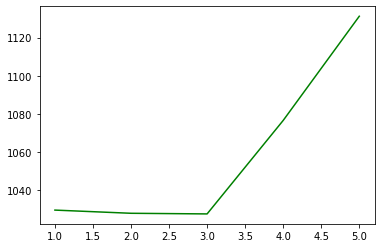

n_components with minimum perplexity: 3


In [30]:
print("for total text")
vectorizer = CountVectorizer(max_features=50000, min_df=5, max_df=0.5)
data_vectorized = vectorizer.fit_transform(total['final_text']) 

print("check optimal topic num: total text")
print("n_components with minimum perplexity:",
      show_perplexity(data_vectorized, start=1, end=5))

## Optimal LDA

In [51]:
total.head()

C:\Users\tkdlz\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,이름,region,ko_check,sentiment,token,tagged,final_text
0,필살기 돈가츠 가로수길점,강남구,와 너무너무너무너무 맛있게 먹었어요 오랜만에 남편이랑 둘이서 방문했는데 이렇게 부드...,1.0,"[오랜만, 남편, 방문, 부드러운, 돈가스, 오랜만, 봐요, 또, 방문, 맛있다, 먹다]","[(와, IC), (너무너무, MAG), (너무너무, MAG), (맛있, VA), ...",오랜만 남편 방문 부드러운 돈가스 오랜만 봐요 또 방문 맛있다 먹다
1,필살기 돈가츠 가로수길점,강남구,맛있게 잘 먹었습니다 ㅎㅎㅎ 멘체 가츠 부드러워요 카레는 살짝 짰어요 ㅠㅠ,1.0,"[잘, 부드러워, 카레, 살짝, 짰, 맛있다, 먹다]","[(맛있, VA), (게, EC), (잘, MAG), (먹, VV), (었, EP)...",잘 부드러워 카레 살짝 짰 맛있다 먹다
2,필살기 돈가츠 가로수길점,강남구,언제 먹어도 맛있네요 ㅎㅎ,1.0,"[먹다, 맛있다]","[(언제, MAG), (먹, VV), (어도, EC), (맛있, VA), (네요, ...",먹다 맛있다
3,필살기 돈가츠 가로수길점,강남구,필살기 돈가스 찾은 이후로 진짜 매번 방문했는데 이제서야 영수증 리뷰 써요 ㅠㅠ 가...,1.0,"[필살기, 돈가스, 이후, 방문, 이제서야, 영수증, 리뷰, 써요, 가로수길, 비슷...","[(필살기, NNG), (돈가스, NNG), (찾, VV), (은, ETM), (이...",필살기 돈가스 이후 방문 이제서야 영수증 리뷰 써요 가로수길 비슷비슷 음식 여긴 최...
4,필살기 돈가츠 가로수길점,강남구,바삭한 건 없고 튀김이랑 고기랑 이중 분리되긴 했지만 잘 먹었어요 직원분이 친절하셔...,1.0,"[바삭, 튀김, 고기, 이중, 분리, 긴, 잘, 직원, 친절, 기분, 점심, 먹다,...","[(바삭, MAG), (한, XSA+ETM), (건, NNB+JX), (없, VA)...",바삭 튀김 고기 이중 분리 긴 잘 직원 친절 기분 점심 먹다 좋다


In [52]:
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

C:\Users\tkdlz\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
t_text = [i for i in positive['token']]
dictionary = corpora.Dictionary(t_text)
dictionary.filter_extremes(no_below=2, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in t_text]

C:\Users\tkdlz\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2022-06-10 16:15:51,500 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2022-06-10 16:15:51,610 : INFO : adding document #10000 to Dictionary<5353 unique tokens: ['남편', '돈가스', '또', '맛있다', '먹다']...>
2022-06-10 16:15:51,720 : INFO : adding document #20000 to Dictionary<8030 unique tokens: ['남편', '돈가스', '또', '맛있다', '먹다']...>
2022-06-10 16:15:51,813 : INFO : adding document #30000 to Dictionary<9971 unique tokens: ['남편', '돈가스', '또', '맛있다', '먹다']...>
2022-06-10 16:15:51,911 : INFO : adding document #40000 to Dictionary<11408 unique tokens: ['남편', '돈가스', '또', '맛있다', '먹다']...>
2022-06-10 16:15:52,009 : INFO : adding document #

In [62]:
#모델링
num_topics = 2
chunksize = 2000
passes = 20
iterations = 400
eval_every = None

temp = dictionary[0]
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every)


C:\Users\tkdlz\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2022-06-10 16:16:00,331 : INFO : using autotuned alpha, starting with [0.5, 0.5]
2022-06-10 16:16:00,334 : INFO : using serial LDA version on this node
2022-06-10 16:16:00,339 : INFO : running online (multi-pass) LDA training, 2 topics, 20 passes over the supplied corpus of 204514 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2022-06-10 16:16:00,340 : INFO : PROGRESS: pass 0, at document #2000/204514
2022-06-10 16:16:01,857 : INFO : optimized alpha [0.6390703, 0.6898787]
2022-06-10 16:16:01,860 : INFO : merging changes from 2000 doc

In [63]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

C:\Users\tkdlz\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2022-06-10 16:22:03,184 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2022-06-10 16:22:03,188 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2022-06-10 16:22:03,193 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2022-06-10 16:22:03,201 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2022-06-10 16:22:03,205 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2022-06-10 16:22:03,211 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2022-06-10 16:22:03,215 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2022-06-10 16:22:03

Average topic coherence: -3.3083.
[([(0.09227245, '좋다'),
   (0.034297008, '친절'),
   (0.023840867, '분위기'),
   (0.022036733, '음식'),
   (0.018867824, '맛'),
   (0.017143646, '많다'),
   (0.017014915, '직원'),
   (0.01636181, '가격'),
   (0.016051108, '방문'),
   (0.013717816, '또'),
   (0.012726146, '웨이팅'),
   (0.010544693, '사람'),
   (0.010255251, '깔끔'),
   (0.01000592, '괜찮다'),
   (0.009258856, '사장'),
   (0.008810675, '서비스'),
   (0.008308841, '만족'),
   (0.007975176, '잘'),
   (0.007368734, '커피'),
   (0.006746475, '구성비')],
  -2.915703788749928),
 ([(0.07947216, '먹다'),
   (0.04614263, '맛'),
   (0.014278922, '최고'),
   (0.0130735, '고기'),
   (0.011768569, '잘'),
   (0.008608778, '파스타'),
   (0.0077153784, '국물'),
   (0.006343246, '맛집'),
   (0.005567073, '있'),
   (0.005118402, '맛나다'),
   (0.004706312, '메뉴'),
   (0.004536524, '생각'),
   (0.0045156647, '처음'),
   (0.0044105914, '피자'),
   (0.0043522427, '김치'),
   (0.0039308444, '만두'),
   (0.003920354, '느낌'),
   (0.0037935697, '많다'),
   (0.0037724983, '냉면'),
   (0

In [64]:
import pickle
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

C:\Users\tkdlz\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
lda_visualization = gensimvis.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(lda_visualization, 'final_positive_lda.html')

C:\Users\tkdlz\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
